# Detecting urbanization extent <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:** 
[ls8_usgs_sr_scene](https://explorer.digitalearth.africa/ls8_usgs_sr_scene)


## Background

Monitoring urbanization is important tool in land and natural resource management. As more land becomes used for human settlement this may create issues with availability of agriculture land and water resources as well as deforestation.

The change in urban area is a key metric in determining Sustainable Development Goal (SDG) Indicator 11.3.1, by comparing it to the population growth rate, to montior urban land consumption.

## Description

This notebook addressess the calculation of land consumption rate (urbanization) using the **Normalized Differential Built Index (NDBI)** and **Normalized Differential Vegetation Index (NDVI)** to determine the **Built-Up Index (BI)**. 

This notebook makes use of **Dask** for parrallel processing and **Geomedian composites** in combining and procesing of the landsat images for the two different years.

This notebook demonstrates how to:

1. Enabling Dask and the Dask Dashboard.
2. Loading data with Dask in chunks.
3. Generate the Geomedian composite for the two different years.
4. Calculate urbanization indices using the Calculate Band Indices function.
5. Plotting a histogram of the two year for the built up areas.

***

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.  

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import sys
import datacube
import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
from odc.ui import with_ui_cbk
import odc.algo
from odc.algo import reshape_for_geomedian
import xarray as xr

sys.path.append('../Scripts')
from deafrica_dask import create_local_dask_cluster
from deafrica_bandindices import calculate_indices
from deafrica_plotting import display_map, rgb
from deafrica_datahandling import load_ard, mostcommon_crs, calc_geomedian

### Set up a Dask cluster

Dask can be used to better manage memory use down and conduct the analysis in parallel. 
For an introduction to using Dask with Digital Earth Africa, see the [Dask notebook](../Beginners_guide/06_Parallel_processing_with_dask.ipynb).

>**Note**: We recommend opening the Dask processing window to view the different computations that are being executed; to do this, see the *Dask dashboard in DE Africa* section of the [Dask notebook](../Beginners_guide/06_Parallel_processing_with_dask.ipynb).

To use Dask, set up the local computing cluster using the cell below.

In [2]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:37143 Dashboard: /user/ahicks/proxy/8787/status,Cluster Workers: 1 Cores: 2 Memory: 14.18 GB


### Connect to the datacube
Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

In [3]:
dc = datacube.Datacube(app='Urbanization')

### Analysis parameters

The following cell set important parameters for the analysis:

* `lat`: The central latitude to analyse (e.g. `14.283`).
* `lon`: The central longitude to analyse (e.g. `-16.921`).
* `buffer`: The number of square degrees to load around the central latitude and longitude. For reasonable loading times, set this as `0.1` or lower.
* `first_year`: The starting year, to use as the baseline of urbanization (e.g. `2017`)
* `second_year`: The ending year to analyse the change in urbanization (e.g. `2019`)

In [4]:
# Alter the lat and lon to suit your study area
lat, lon = 6.58, -1.68

# Provide your area of extent here
buffer = 0.1

# Combine central lat,lon with buffer to get area of interest
lat_range = (lat-buffer, lat+buffer)
lon_range = (lon-buffer, lon+buffer)

# Change the years values also here
# Note: Landsat 8 starts from 2013
first_year = 2015
second_year = 2019

## View the selected location
The next cell will display the selected area on an interactive map.
Feel free to zoom in and out to get a better understanding of the area you'll be analysing.
Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [5]:
display_map(lon_range, lat_range)

## Load cloud-masked Landsat-8 data
The first step in this analysis is to load in Landsat data for the `lat_range`, `lon_range` and `time_range` we provided above. 

The code below uses the `load_ard` function to load in data from the Landsat-8 satellite for the area and time specified. For more information, see the [Using load_ard notebook](../Frequently_used_code/Using_load_ard.ipynb).
The function will also automatically mask out clouds from the dataset, allowing us to focus on pixels that contain useful data:

In [6]:
# Create a query
query = {
    'time': (f'{first_year}', f'{second_year}'),
    'x': lon_range,
    'y': lat_range,
    'group_by': 'solar_day',
    'resolution': (-30, 30),
    'align': (15, 15)
}

# Determine the most common used CRS for the product
output_crs = mostcommon_crs(dc=dc, product='ls8_usgs_sr_scene', query=query)

# Create a dataset of the requested data 
ds = load_ard(
    dc=dc, 
    products=['ls8_usgs_sr_scene'],
    output_crs=output_crs,
    dask_chunks={'time': 1, 'x': 500, 'y': 500},
    **query
)

Using pixel quality parameters for USGS Collection 1
Finding datasets
    ls8_usgs_sr_scene
Applying pixel quality/cloud mask
Returning 102 time steps as a dask array


## Calculate the geomedian for each year

Here we group the timeseries into years and calculate the geomedian (geometric-median) for each year.

For more information about computing geomedians, see the [Generating Geomedian Composites](../Frequently_used_code/Generating_geomedian_composites.ipynb) notebook.

In [7]:
# change the data into an array so it can be used with `map`
da = reshape_for_geomedian(ds)

# groupby year, then calculate the geomedian on each year
# For Landsat c1, the max_value is 10,000
geomedian_da = da.groupby('time.year').map(calc_geomedian, min_value=0, max_value=10000)

# Change back into a xr.Dataset
geomedian_all_years = geomedian_da.to_dataset(dim='band')
geomedian_all_years

<xarray.Dataset>
Dimensions:          (x: 740, y: 740, year: 4)
Coordinates:
  * x                (x) float64 6.349e+05 6.349e+05 ... 6.57e+05 6.57e+05
  * y                (y) float64 7.386e+05 7.386e+05 ... 7.165e+05 7.164e+05
  * year             (year) int64 2015 2016 2017 2019
Data variables:
    coastal_aerosol  (y, x, year) float32 dask.array<chunksize=(500, 500, 1), meta=np.ndarray>
    blue             (y, x, year) float32 dask.array<chunksize=(500, 500, 1), meta=np.ndarray>
    green            (y, x, year) float32 dask.array<chunksize=(500, 500, 1), meta=np.ndarray>
    red              (y, x, year) float32 dask.array<chunksize=(500, 500, 1), meta=np.ndarray>
    nir              (y, x, year) float32 dask.array<chunksize=(500, 500, 1), meta=np.ndarray>
    swir1            (y, x, year) float32 dask.array<chunksize=(500, 500, 1), meta=np.ndarray>
    swir2            (y, x, year) float32 dask.array<chunksize=(500, 500, 1), meta=np.ndarray>
    sr_aerosol       (y, x, year) float32 dask.array<chunksize=(500, 500, 1), meta=np.ndarray>
    radsat_qa        (y, x, year) float32 dask.array<chunksize=(500, 500, 1), meta=np.ndarray>
    pixel_qa         (y, x, year) float32 dask.array<chunksize=(500, 500, 1), meta=np.ndarray>
Attributes:
    crs:           epsg:32630
    grid_mapping:  spatial_ref
    nodata:        nan

We can see now that the `time` dimension has been replaced by the `year` dimension. Since the query was for alll data between our target years, we have data for all years in the range.  Since we are only looking at 2 years, we will just select those.

>**Note:** As we are using `dask`, no data reading or calculations have yet taken place.

In [8]:
year_list = [first_year, second_year]
geomedian_sel = geomedian_all_years.sel(year=year_list)

### Load the data and calculate the geomedian for the selected years

Now that we have the geomedians for the 2 years we want to analyse, we can trigger the delay-loading and calculation.

This will use the `dask` cluster we set up earlier. You can follow the progress of this step by opening the Dask processing window. See the *Dask dashboard in DE Africa* section of the [Dask notebook](../Beginners_guide/06_Parallel_processing_with_dask.ipynb). 

In [9]:
%%time
geomedian_sel.load()

CPU times: user 7.6 s, sys: 493 ms, total: 8.09 s
Wall time: 2min 25s


<xarray.Dataset>
Dimensions:          (x: 740, y: 740, year: 2)
Coordinates:
  * x                (x) float64 6.349e+05 6.349e+05 ... 6.57e+05 6.57e+05
  * y                (y) float64 7.386e+05 7.386e+05 ... 7.165e+05 7.164e+05
  * year             (year) int64 2015 2019
Data variables:
    coastal_aerosol  (y, x, year) float32 249.28506 286.10214 ... 150.01439
    blue             (y, x, year) float32 388.41168 378.30603 ... 247.01585
    green            (y, x, year) float32 751.36865 710.44543 ... 597.0105
    red              (y, x, year) float32 664.2009 567.4489 ... 398.02042
    nir              (y, x, year) float32 3063.2385 3664.065 ... 3541.959
    swir1            (y, x, year) float32 2139.5422 2258.3523 ... 1804.0243
    swir2            (y, x, year) float32 1127.145 1171.6488 ... 800.03815
    sr_aerosol       (y, x, year) float32 201.52606 179.77573 ... 160.01982
    radsat_qa        (y, x, year) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    pixel_qa         (y, x, year) float32 331.88788 321.99997 ... 321.99994
Attributes:
    crs:           epsg:32630
    grid_mapping:  spatial_ref
    nodata:        nan

## View the satellite data
We can plot the two years to visually compare them:

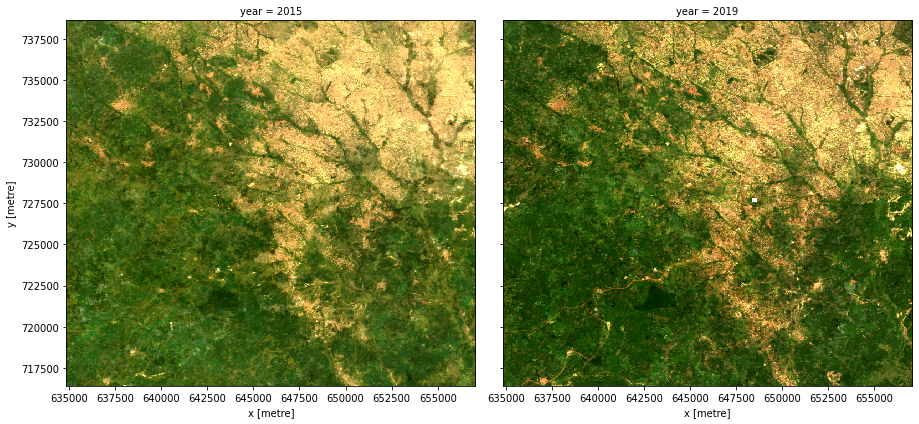

In [10]:
rgb(geomedian_sel, col='year')

## Calculating the indices

There are a number of ways to measure urbanization.
This notebook follows the approach by [He et al.](https://www.tandfonline.com/doi/pdf/10.1080/01431161.2010.481681), which combines the normalized difference built-up index (NDBI) and the normalized difference vegetation index (NDVI) to calculate built-up index (BU) as

$$ \text{BU} = \text{NDBI} - \text{NDVI},$$

where

$$\text{NDBI} = \frac{\text{SWIR} - \text{NIR}}{\text{SWIR} - \text{NIR}},$$

and

$$\text{NDVI} = \frac{\text{NIR} - \text{Red}}{\text{NIR} - \text{Red}}.$$

The intuition being that urban areas will have high NDBI and low NDVI, corresponding to high BU, whereas vegetated areas will have low NDBI and high NDVI, corresponding to low BU. 

All of these indices are available through the [calculate_indices](../Frequently_used_code/Calculating_band_indices.ipynb) function, imported from [deafrica_bandindices.py](../Scripts/deafrica_bandindices.py).

In [11]:
# Calculate BU Index, as well as NDVI and NDBI, using the formulas above
geomedian_with_indices = calculate_indices(geomedian_sel, index=['NDVI', 'NDBI', 'BUI'], collection = 'c1')

#### Normalised Difference Built-up Index (NDBI)

We will first look at the built-up index.  This is in the range of 1 to -1.

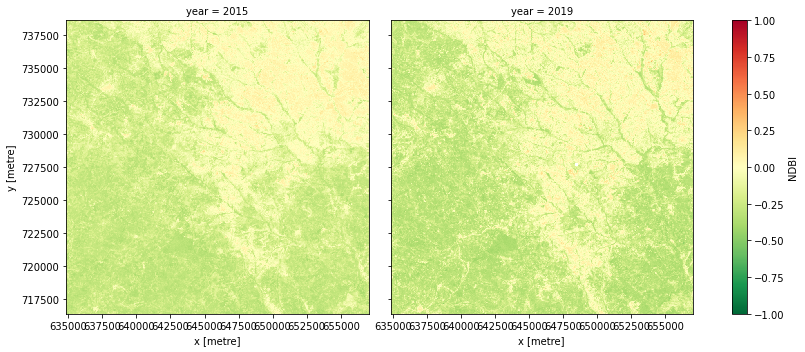

In [12]:
geomedian_with_indices.NDBI.plot(
    col='year',
    vmin=-1, 
    vmax=1, 
    cmap='RdYlGn_r',
    figsize=(12, 5),
    robust=True
);

Here we find the NDBI is not very strong, but we can adjust the plot to better show the built area.

We can ignore values below 0, and change the colour map so that smaller values are easier to see:

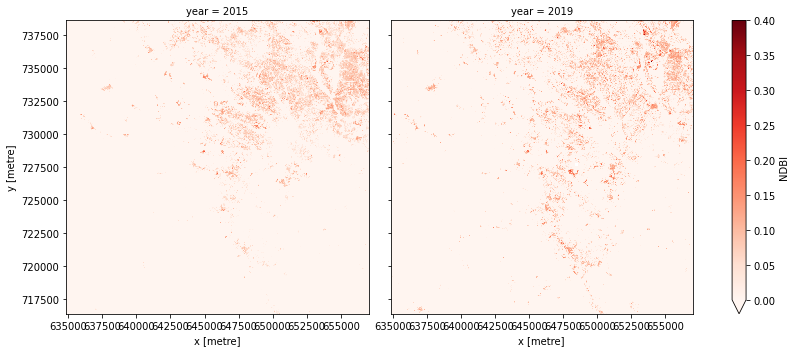

In [13]:
geomedian_with_indices.NDBI.plot(
    col='year',
    vmin=0, 
    vmax=0.4, 
    cmap='Reds',
    figsize=(12, 5),
    robust=True
);

#### Normalized Difference Vegetation Index (NDVI)

To find vegetated areas, we use NDVI. It is in the range 1 (high vegitation signal) to -1 (high non-vegetation signal).

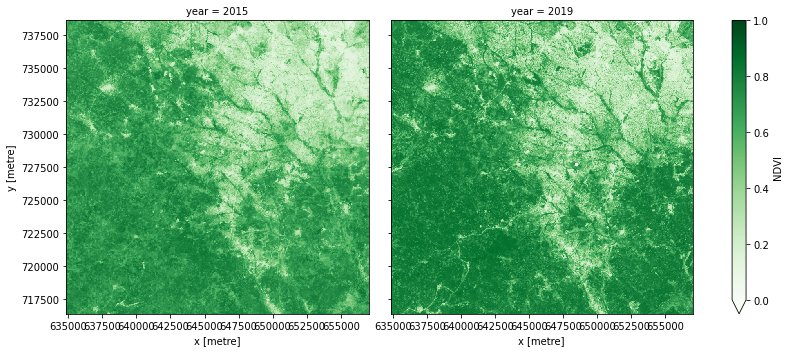

In [14]:
geomedian_with_indices.NDVI.plot(
    col='year',
    vmin=0, 
    vmax=1, 
    cmap='Greens',
    figsize=(12, 5),
    robust=True
);

#### Built-Up Index (BUI)

As we can see above, built up areas tend to have low vegetation, and areas of high vegetation tend to have a low NDBI value.

The Built-Up Index amplifies this effect: it ranges from 2 (high NDBI and low vegetation) to -2 (high vegetation and low NDBI).

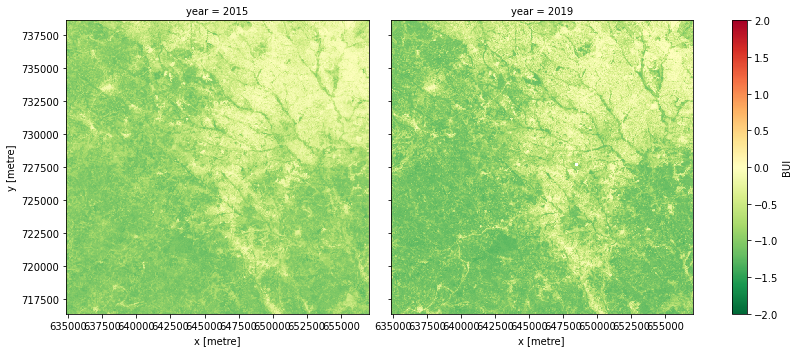

In [15]:
geomedian_with_indices.BUI.plot(
    col='year',
    vmin=-2, 
    vmax=2, 
    cmap='RdYlGn_r',
    figsize=(12, 5),
    robust=True
);

## Calculate the urban area

Again we see that the effect is not very strong, so we can adjust the color values.

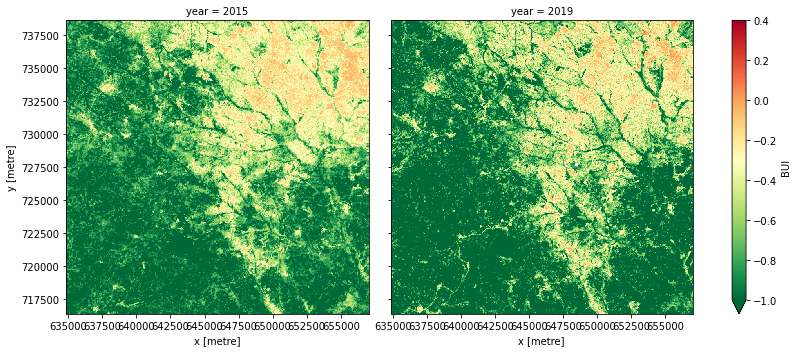

In [16]:
geomedian_with_indices.BUI.plot(
    col='year',
    vmin=-1, 
    vmax=0.4, 
    cmap='RdYlGn_r',
    figsize=(12, 5),
    robust=True
);

For the given built-up index, we need a method to decide whether a pixel is considered as "urban".
If there was classification label data available, it might be possible to train a machine learning algorithm to directly identify pixels as urban or not.
Without these labels, we can do a simple threshold to specify that pixels with BU values above the threshold are urban.
Based on the image above, we specify a threshold of $\text{BU} \geq -0.4$.
> **Note:** You may wish to experiment with the threshold value by changing it below. 
Examine the plot above to choose reasonable values.

Once the threshold is defined, the cell below classifies pixels as urban (value of 1) or non-urban (value of 0).

In [17]:
year_threshold = -0.4

### Apply the threshold

We apply the threshold and plot both years side-by-side.

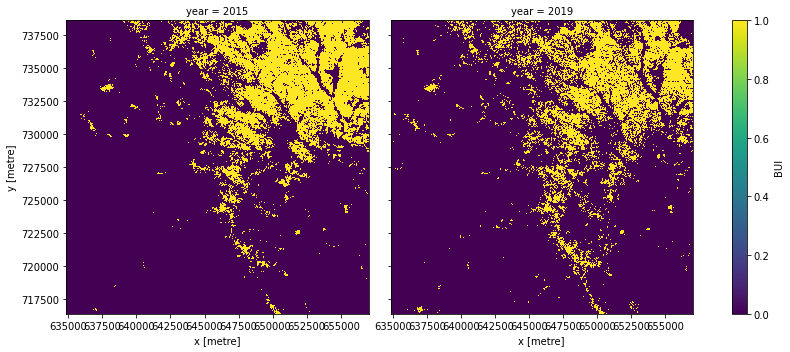

In [18]:
urban_area = (geomedian_with_indices.BUI > year_threshold).astype(int)
urban_area.plot(
    col='year',
    figsize=(12, 5),
    robust=True
);

## Plotting the changes in area

We can convert the data above into a total area for each year, then plot a bar graph.

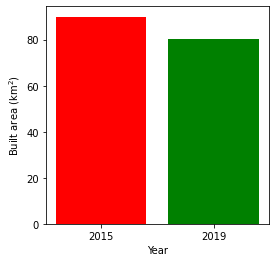

In [19]:
pixel_length = query["resolution"][1]  # in metres
m_per_km = 1000  # conversion from metres to kilometres
area_per_pixel = pixel_length**2 / m_per_km**2

urban_area_km2 = urban_area.sum(dim=['x', 'y']) * area_per_pixel

# Plot the resulting area through time
fig, axes = plt.subplots(1, 1, figsize=(4, 4))
plt.bar([0, 1], 
        urban_area_km2, 
        tick_label = urban_area_km2.year, 
        width = 0.8, 
        color = ['red', 'green'])
axes.set_xlabel("Year")
axes.set_ylabel("Built area (km$^2$)")
plt.show()

### Analysing the plot 
Here we see a decrease of urban area over time. While this is unexpected, if we look at the true-colour plots we did comparing the years in the [View the satellite data](#View-the-satellite-data) section, we can see that the first year looks much drier than the second.  We can also see that while there are areas that have become urbanized around the edges, there is an infill of vegetation in some parts of the city.

### Compare the years

If we subtract BUI of the first year from the second year, we get the change.
We can also threshold this value so that we can clearly see areas of meaningful change.

In this plot, we can see areas that have seen significant change, either becoming more or less urbanized.

In [20]:
change_threshold = 0.5

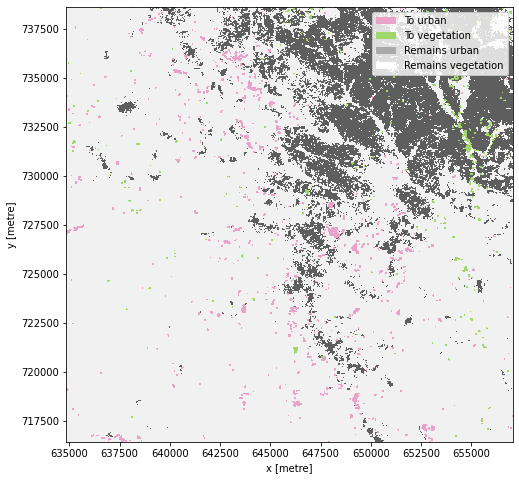

In [21]:
# Calculate the change in BU between the years
urban_change = geomedian_with_indices.BUI.sel(year=second_year) - geomedian_with_indices.BUI.sel(year=first_year)

# Plot urban extent from first year in grey as a background
baseline_urban = xr.where(urban_area.sel(year=first_year), 1, np.nan)
plot = urban_area.sel(year=first_year).plot(    
    cmap='Greys',
    vmin=-0.2, vmax=1.5,
    size=8,
    aspect=urban_area.y.size / urban_area.y.size,
    add_colorbar=False,
);

# Plot the meaningful change in urban area
# Colors from https://colorbrewer2.org/?type=diverging&scheme=PiYG&n=3
to_urban = '#e9a3c9'
from_urban = '#a1d76a'
xr.where(urban_change > change_threshold, 1, np.nan).plot(ax=plot.axes, add_colorbar=False, cmap=ListedColormap([to_urban]));
xr.where(urban_change < -change_threshold, 1, np.nan).plot(ax=plot.axes, add_colorbar=False, cmap=ListedColormap([from_urban]));

# Add the legend
plot.axes.legend(
    [Patch(facecolor=to_urban), Patch(facecolor=from_urban), Patch(facecolor='darkgrey'), Patch(facecolor='white')], 
    ['To urban', 'To vegetation', 'Remains urban', 'Remains vegetation'],
);

## Drawing Conclusions

Here are some questions to think about:

* How well does the Built-Up Index work in urban areas with vegetation?
* What could be done to stop the change in vegetation in urban areas from affecting the 
* What data do you need to calculate Sustainable Development Goal (SDG) Indicator 11.3.1?

## Next steps

When you are done, return to the [Analysis parameters](#Analysis-parameters) section, modify some values (e.g. `lat`, `lon` or `time`) and rerun the analysis.

You can use the interactive map in the [View the selected location](#View-the-selected-location) section to find new central latitude and longitude values by panning and zooming, and then clicking on the area you wish to extract location values for.
You can also use Google maps to search for a location you know, then return the latitude and longitude values by clicking the map.

If you're going to change the location, you'll need to make sure Landsat-8 data is available for the new location, which you can check at the [Digital Earth Africa Explorer](https://explorer.digitalearth.africa/ls8_usgs_sr_scene).


For more advanced methods of urban extent detection, see the [Machine Learning with ODC](../Real_world_examples/Machine_learning_with_ODC.ipynb) notebook, which uses a decision tree to classify urban area. 

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** April 2020

**Compatible datacube version:** 

In [22]:
print(datacube.__version__)

1.8.0


## Tags
Browse all available tags on the DE Africa User Guide's [Tags Index](https://) (placeholder as this does not exist yet)